음악의 온셋(onset)을 설명하고, 온셋을 감지하기 위해 변화를 포착하는 노벨티 함수(novelty function)의 종류(4가지)를 다루고 비교한다. 또한 피크를 선택하는 방법을 알아본다.

In [66]:
import numpy as np
from scipy import signal
from  matplotlib import pyplot as plt
import librosa
import librosa.display
import pandas as pd

import IPython.display as ipd
from IPython.display import Image, Audio

from utils.plot_tools import *
path_img = '../img/7.tempo_and_beat_tracking/'
path_data = '../data_FMP/'

# Musical Onset

- 음악적 온셋(onset)의 개념은 다소 모호할 수 있으며 attack 또는 trasient과 같은 다른 개념과 관련이 있다.
- 피아노와 같은 악기에서 음을 연주할 때 음악 톤의 시작 부분에서 갑자기 에너지가 증가하는 경우가 많다.
- 음의 **attack**은 사운드가 쌓이는 단계를 말하며 일반적으로 진폭 엔벨로프가 급격히 증가한다.
- **transient**은 일반적으로 음악 톤이나 소리의 이벤트 시작 부분에서 발생하는 짧은 지속 시간과 높은 진폭의 소음과 같은 사운드 구성 요소를 나타낸다.
- 어택 및 트랜지언트와 달리 음의 **onset**은 트랜지언트의 시작을 표시하는 단일 순간(기간이 아님) 또는 트랜지언트를 안정적으로 감지할 수 있는 가장 빠른 시점을 나타낸다.

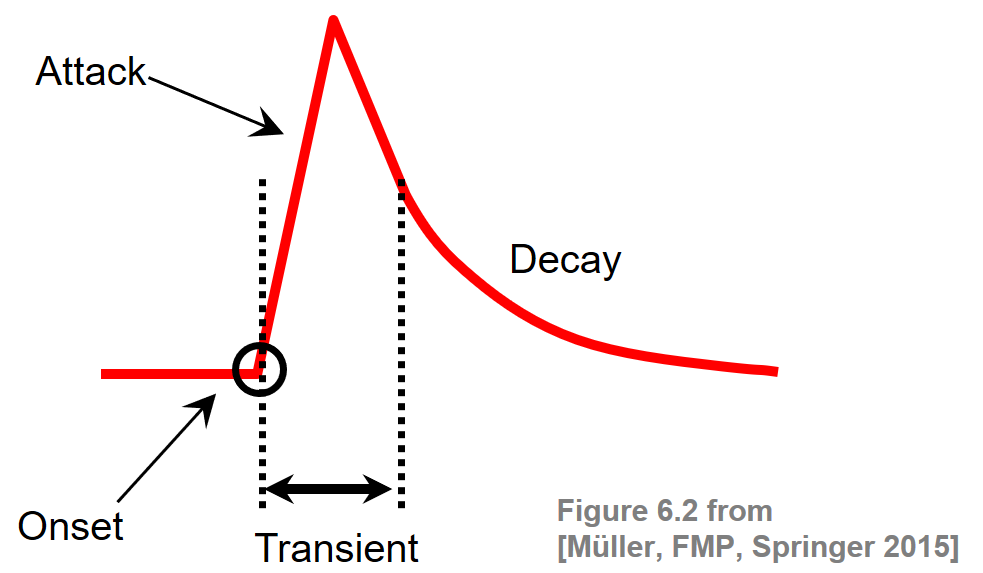

In [67]:
Image(path_img + "FMP_C6_F02b.png", width=400)

- 직관적으로 말해서 **onset detection**는 음악 녹음에서 발생하는 음 또는 기타 음악 이벤트의 시작 시간을 결정하는 작업이다. 
- 신호에서 음 시작을 감지하기 위한 일반적인 아이디어는 트랜지언트 영역의 시작을 알리는 갑작스러운 변화를 캡처하는 것이다. 
- 뚜렷한 어택 단계가 있는 음의 경우 신호의 진폭 엔벨로프가 증가하기 시작하는 시간 위치를 찾아 시작 후보를 결정할 수 있다. 
- 다음 그림에서는 딸깍 소리와 피아노 소리(음표 C4 연주)의 파형과 스펙트로그램을 보여준다.

In [13]:
def plot_wav_spectrogram(fn_wav, xlim=None, audio=True):
    """Plot waveform and computed spectrogram and may display audio
    """
    Fs = 22050
    x, Fs = librosa.load(fn_wav, sr=Fs) 
    plt.figure(figsize=(6,2)) 
    ax = plt.subplot(1,2,1)
    plot_signal(x, Fs, ax=ax)
    if xlim!=None: plt.xlim(xlim)
    ax = plt.subplot(1,2,2)
    N, H = 512, 256 
    X = librosa.stft(y=x, n_fft=N, hop_length=H, win_length=N, window='hann')
    Y = np.log(1 + 10 * np.abs(X))
    plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax], colorbar=False)
    plt.ylim([0,5000])
    if xlim is not None: plt.xlim(xlim)
    plt.tight_layout()
    plt.show()
    if audio: ipd.display(ipd.Audio(x, rate=Fs))

In [69]:
fn_wav1 = 'FMP_C6_F04_Impulse.wav'
fn_wav2 = 'FMP_C6_F04_NoteC4_Piano.wav'

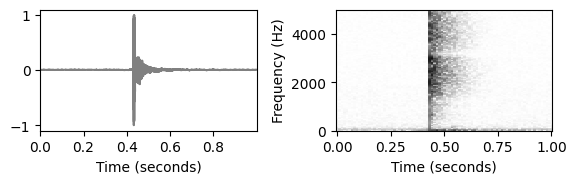

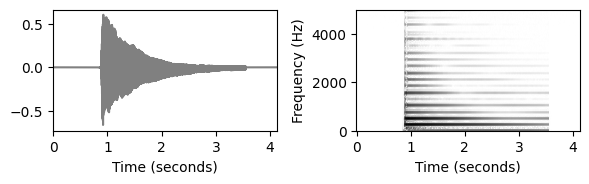

In [70]:
plot_wav_spectrogram(path_data+fn_wav1)
plot_wav_spectrogram(path_data+fn_wav2)

- 부드러운 온셋과 흐릿한 음 전환이 있는 비(非)타악기 음악과 같이 명확한 어택 단계가 없는 경우 온셋 감지가 훨씬 더 어렵다. 예를 들어 바이올린 소리의 파형은 피아노 소리처럼 급격한 변화가 아니라 느린 에너지 증가를 보일 수 있다. 부드러운 소리의 경우 정확한 시작 위치를 결정하거나 정의하기조차 어렵다. 

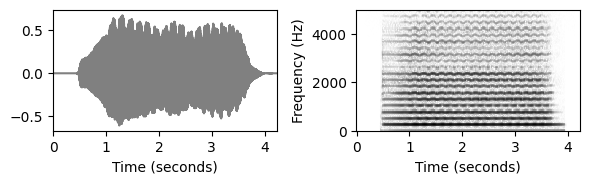

In [71]:
fn_wav3 = 'FMP_C3_NoteC4_Violin.wav'
plot_wav_spectrogram(path_data+fn_wav3)

- 복잡한 다성 음악을 다룰 때 개별 음 시작점을 감지하는 것은 훨씬 더 어려워진다. 
- 동시에 발생하는 사운드 이벤트는 신호 에너지의 중요한 변화를 측정할 수 없는 마스킹(masking) 효과를 초래할 수 있다. 

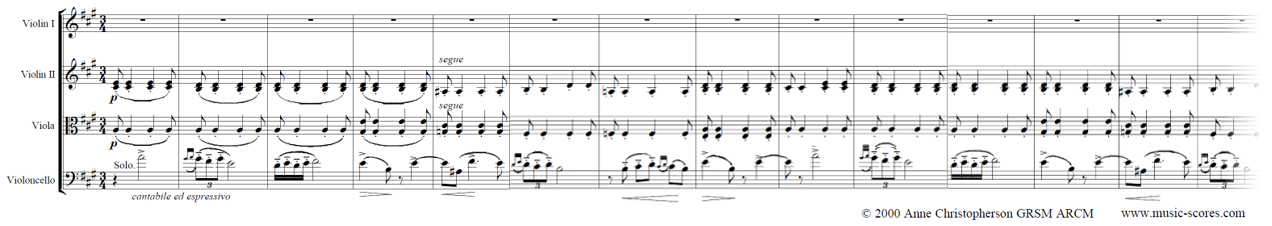

In [72]:
Image(path_img+"FMP_C6_Audio_Borodin-sec39_RWC_score.png", width=700)

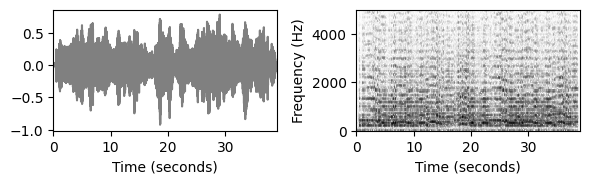

Plot of the first six seconds:


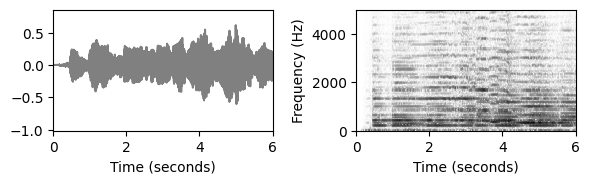

In [74]:
fn_wav4 = "FMP_C6_Audio_Borodin-sec39_RWC.wav"
plot_wav_spectrogram(path_data+fn_wav4, audio=False)

print('Plot of the first six seconds:')
plot_wav_spectrogram(path_data+fn_wav4, xlim=[0,6])

## General Pipeline

- 온셋 감지를 위한 많은 방식은 유사한 알고리즘 파이프라인을 따르지만 온셋 후보를 도출하기 위해 활용되는 신호 속성이 다르다. 이 파이프라인에서 주요 단계는 다음과 같다.
     * 먼저 신호는 관심 속성을 더 잘 반영하는 적절한 특징 표현으로 변환된다.
     * 그런 다음 특징 시퀀스에 미분 연산자 유형을 적용하고 **노벨티 함수 (novelty function)** 를 도출한다.
     * 마지막으로 피크(peak) 선택 알고리즘을 사용하여 온셋 후보를 찾는다.

- 특히 주어진 음악 신호를 신호 에너지 또는 스펙트럼의 특정 변화를 캡처하는 **노벨티(novelty) 표현**으로 변환하는 방법을 본다. 이러한 표현의 피크는 음의 온셋 후보에 대한 좋은 지표를 제공한다.

    * 에너지-기반 novelty
    * 스펙트럼-기반 novelty
    * 단계-기반 novelty
    * 복소-영역 novelty

## 예시: Another One Bites the Dust

- 예를 들어 Queen의 "Another one bites the dust"를 살펴보자. 베이스로만 연주되는 두 개의 16분 음표로 구성된 색다른 비트로 시작하여 네 개의 타악기 비트(킥 드럼, 스네어 드럼, 하이햇 및 베이스로 연주)가 이어진다. 또한 두 개의 후속 비트 사이에 추가 하이햇 스트로크가 있다. 다음 그림은 온셋 위치에 주석이 달린 파형을 보여준다.

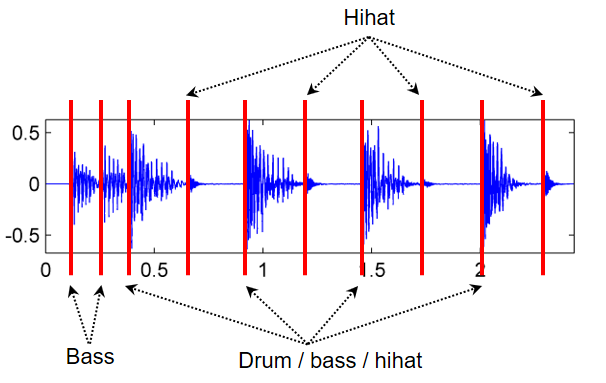

In [75]:
ipd.display(Image(path_img+"FMP_C6_F01a.png", width=400))
ipd.display(Audio(path_data+"FMP_C6_F01_Queen.wav"))

- 다음 스펙트로그램 표현은 4분음표 드럼 비트와 하이햇 사운드가 트랜지언트(수직선)와 함께 진행되는 반면 처음 두 개의 베이스 소리는 확산 온셋 속성이 더 크다는 것을 보여준다.

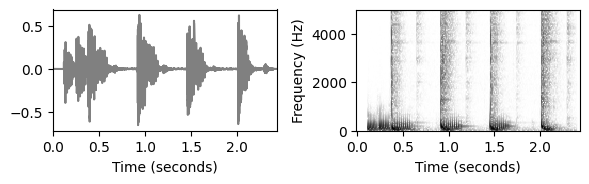

In [76]:
fn_wav = 'FMP_C6_F01_Queen.wav'
plot_wav_spectrogram(path_data+fn_wav, audio=False)

In [77]:
def read_annotation_pos(fn_ann, label='', header=True, print_table=False):
    """Read and convert file containing either list of pairs (number,label) or list of (number)

    Args:
        fn_ann (str): Name of file
        label (str): Name of label (Default value = '')
        header (bool): Assumes header (True) or not (False) (Default value = True)
        print_table (bool): Prints table if True (Default value = False)

    Returns:
        ann (list): List of annotations
        label_keys (dict): Dictionaries specifying color and line style used for labels
    """
    df = pd.read_csv(fn_ann, sep=';', keep_default_na=False, header=0 if header else None)
    if print_table:
        print(df)
    num_col = df.values[0].shape[0]
    if num_col == 1:
        df = df.assign(label=[label] * len(df.index))
    ann = df.values.tolist()

    label_keys = {'beat': {'linewidth': 2, 'linestyle': ':', 'color': 'r'},
                  'onset': {'linewidth': 1, 'linestyle': ':', 'color': 'r'}}
    return ann, label_keys

In [78]:
def compute_local_average(x, M):
    """Compute local average of signal
    Args:
        x (np.ndarray): Signal
        M (int): Determines size (2M+1) in samples of centric window  used for local average
    Returns:
        local_average (np.ndarray): Local average signal
    """
    L = len(x)
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average


def compute_novelty_spectrum(x, Fs=1, N=1024, H=256, gamma=100.0, M=10, norm=True):
    """Compute spectral-based novelty function
    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate (Default value = 1)
        N (int): Window size (Default value = 1024)
        H (int): Hop size (Default value = 256)
        gamma (float): Parameter for logarithmic compression (Default value = 100.0)
        M (int): Size (frames) of local average (Default value = 10)
        norm (bool): Apply max norm (if norm==True) (Default value = True)
    Returns:
        novelty_spectrum (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
    """
    X = librosa.stft(y=x, n_fft=N, hop_length=H, win_length=N, window='hann')
    Fs_feature = Fs / H
    Y = np.log(1 + gamma * np.abs(X))
    Y_diff = np.diff(Y)
    Y_diff[Y_diff < 0] = 0
    novelty_spectrum = np.sum(Y_diff, axis=0)
    novelty_spectrum = np.concatenate((novelty_spectrum, np.array([0.0])))
    if M > 0:
        local_average = compute_local_average(novelty_spectrum, M)
        novelty_spectrum = novelty_spectrum - local_average
        novelty_spectrum[novelty_spectrum < 0] = 0.0
    if norm:
        max_value = max(novelty_spectrum)
        if max_value > 0:
            novelty_spectrum = novelty_spectrum / max_value
    return novelty_spectrum, Fs_feature

   position  label
0  0.117460  onset
1  0.247619  onset
2  0.372698   beat
3  0.646349  onset
4  0.911111   beat
5  1.184762  onset
6  1.445442   beat
7  1.735238  onset
8  2.000000   beat
9  2.287619  onset


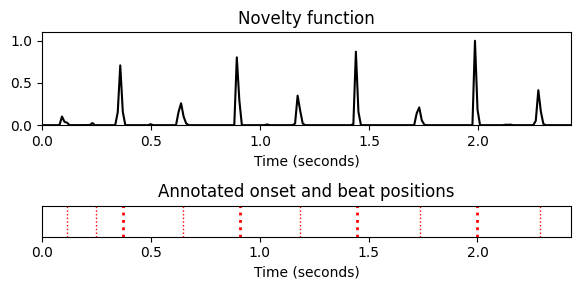

In [80]:
fn_ann = 'FMP_C6_F01_Queen.csv'
ann, label_keys = read_annotation_pos(path_data+fn_ann, print_table=True)

x, Fs = librosa.load(path_data+fn_wav)
x_duration = len(x)/Fs
nov, Fs_nov = compute_novelty_spectrum(x, Fs=Fs)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6, 3))
plot_signal(nov, Fs_nov, ax=ax[0], color='k', title='Novelty function');
plot_annotation_line(ann, ax=ax[1], label_keys=label_keys,
                    time_min=0, time_max=x_duration)
ax[1].set_title('Annotated onset and beat positions')
ax[1].set_xlabel('Time (seconds)')

plt.tight_layout()

- 마지막으로 피크 선택(peak picking) 전략을 적용하여 노벨티 함수의 **로컬 최대값** 또는 **피크**를 찾는다.
- 피크의 위치는 온셋 위치에 대한 후보이다. 다음 코드 셀에서는 [`scipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) 함수에서 제공하는 피크 선택 전략을 적용한다. 
- 또한 원본 오디오 녹음에 추가된 클릭(click) 트랙을 통해 **음성화(sonification)** 와 함께 피크의 시각화를 생성한다.

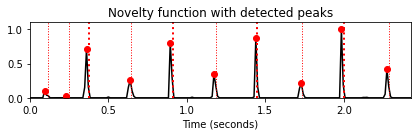

In [81]:
peaks, properties = signal.find_peaks(nov, prominence=0.02)
T_coef = np.arange(nov.shape[0]) / Fs_nov
peaks_sec = T_coef[peaks]
fig, ax, line = plot_signal(nov, Fs_nov, color='k', 
                    title='Novelty function with detected peaks')
plot_annotation_line(ann, ax=ax, label_keys=label_keys, 
                    nontime_axis=True, time_min=0, time_max=x_duration)
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()

x_peaks = librosa.clicks(times=peaks_sec, sr=Fs, click_freq=1000, length=len(x)) # click sound
ipd.display(Audio(x + x_peaks, rate=Fs))

# 에너지 기반 노벨티 (Energy-Based Novelty)

## Local 에너지 함수

- 종종 음의 온셋은 신호 에너지의 갑작스러운 증가와 함께 진행된다.
- 이 가정에 기초하여 음 시작점을 감지하는 간단한 방법은 신호를 각 시간 인스턴스에 대한 신호의 로컬(local) 에너지를 나타내는 함수로 변환한 다음 이 함수에서 급격한 변화를 찾는 것이다.
- $x:\mathbb{Z}\to\mathbb{R}$를 DT(discrete time)-signal이라고 하자. 또한, $w:[-M:M]\to\mathbb{R} for some $M\in\mathbb{N}$$를 시간 0을 중심으로 하는 종 모양의 창 함수(예: Hann window)라고 하자.
- $w$에 대한 $x$의 **로컬 에너지**는 다음과 같이 주어진 함수 $E_w^x:\mathbb{Z}\to\mathbb{R}$로 정의된다.
     - $ E_w^x(n) := \sum_{m=-M}^{M} |x(n+m)w(m)|^2 = \sum_{m\in\mathbb{Z}}| x(m)w(m-n)|^2 $

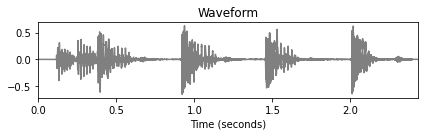

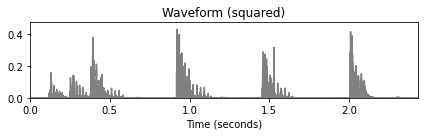

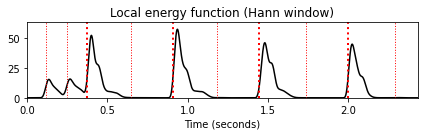

In [83]:
ann, label_keys = read_annotation_pos(path_data+fn_ann)

x, Fs = librosa.load(path_data+fn_wav) # Queen example
x_duration = len(x)/Fs

N = 2048
w = signal.hann(N)

#Calculate local energy
x_square = x**2
energy_local = np.convolve(x_square, w**2, 'same')

plot_signal(x, Fs, title='Waveform')
plot_signal(x_square, Fs, title='Waveform (squared)')
fig, ax, line = plot_signal(energy_local, Fs, color='k', 
                    title='Local energy function (Hann window)')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

## Discrete Derivative and Half-Wave Rectification

- 에너지 변화를 측정하기 위해 로컬 에너지 함수의 미분을 취한다. 불연속적인 경우, 그러한 도함수를 실현하는 가장 쉬운 방법은 두 개의 후속 에너지 값 사이의 차이를 취하는 것이다. 또한 우리는 에너지 증가(감소가 아닌)에 관심이 있기 때문에 양의 차이만 유지하고 음의 차이는 0으로 설정할 수 있다. 후자의 단계를 **half-wave rectification**라고 하며 다음과 같이 표기한다.

$$
   |r|_{\geq 0} := \frac{r+|r|}{2} =
   \left\{\begin{array}{ll}
    r, &\,\, \mbox{if $r\geq 0$,}\\
    0, &\,\, \mbox{if $r< 0$,}
\end{array}\right.\\
\text{for}\ r\in\mathbb{R}. 
$$



- 전체적으로 다음과 같이 주어진 **에너지 기반 노벨티 함수** $\Delta_\mathrm{Energy}:\mathrm{Z}\to\mathbb{R}$를 얻는다.

$$
    \Delta_\mathrm{energy}(n):= |E_w^x(n+1)-E_w^x(n)|_{\geq 0}
$$

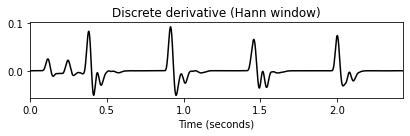

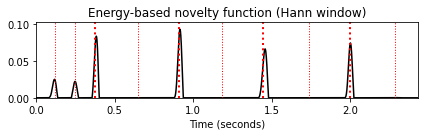

In [84]:
#Differentiation and half-wave rectification
energy_local_diff = np.diff(energy_local)
energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
novelty_energy = np.copy(energy_local_diff)
novelty_energy[energy_local_diff < 0] = 0

plot_signal(energy_local_diff, Fs, color='k', 
                    title='Discrete derivative (Hann window)')
fig, ax, line = plot_signal(novelty_energy, Fs, color='k',
                    title='Energy-based novelty function (Hann window)')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

- 이 노벨티 함수는 타악기 비트에 많은 에너지가 포함되어 있음을 잘 나타낸다. 그러나 그 사이의 저에너지 하이햇 스트로크는 보이지 않는다. 
- 또한 간단한 프레임별 차이 함수를 적용할 때 이 절차에서 종 모양의 Hann window에 의해 도입된 **스무딩(smoothing) 효과**가 필수적이라는 점에 유의해야 한다. 예를 들어 직사각형 창을 대신 사용하면 차이 함수가 노이즈가 많은 에너지 함수로 이어지는 작은 로컬 변동에 반응한다.

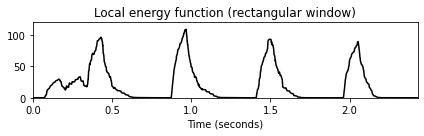

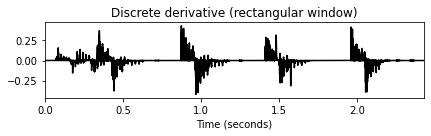

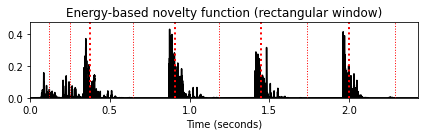

In [85]:
# Use rectangular window
w = signal.boxcar(N)
x_square = x**2
energy_local = np.convolve(x_square, w**2, 'same')
energy_local_diff = np.diff(energy_local)
energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
novelty_energy = np.copy(energy_local_diff)
novelty_energy[energy_local_diff < 0] = 0

fig, ax, line = plot_signal(energy_local, Fs, color='k',
                    title='Local energy function (rectangular window)')
plot_signal(energy_local_diff, Fs, color='k', 
                    title='Discrete derivative (rectangular window)')
fig, ax, line = plot_signal(novelty_energy, Fs, color='k', title='Energy-based novelty function (rectangular window)')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

## 로그 압축 (Logarithmic Compression)

- 소리 강도(intensity)에 대한 인간의 인식이 본질적으로 대수적(logarithmic)이라는 사실을 설명하기 위해 예를 들어 로그 데시벨로 전환하거나 로그 압축을 적용하여 에너지 값에 로그를 적용하는 경우가 많다.
- 후자의 경우 $\Gamma_\gamma:\mathbb{R}_{>0} \to \mathbb{R}_{>0}$ 함수를 사용한다.
    - $ \Gamma_\gamma(v):=\log(1+ \gamma \cdot v),$
    - 양의 상수 $\gamma\in\mathbb{R}_{>0}$는 압축 정도를 조절

- 그 결과 노벨티 함수는 다음과 같이 주어진다.
    - $ \Delta_\mathrm{Energy}^\mathrm{Log}(n):= |\Gamma_\gamma(E_w^x(n+1))-\Gamma_\gamma(E_w^x(n))|_{\geq 0}.$
    
- 창 길이 $N$ 외에도 다음 구현에서 홉(hop) 크기 매개변수 $H$를 도입하여 계산된 노벨티의 특징 샘플링 비율을 줄일 수 있다.
- 또한 최대값으로 나누어 노벨티 함수를 정규화한다.
- 다음 그림에서 로그 노벨티 함수를 사용했을 때 약한 하이햇 온셋 부분이 표시되는 것을 관찰할 수 있다($t=1.3~\mathrm{sec}$ 및 $t=2.3~\mathrm{sec}$ 참조). 
- 로그 압축의 단점으로 일부 소음과 같은 소리 구성 요소가 증폭되어 거짓의 피크가 발생할 수 있다.
- 이 예에서 볼 수 있듯이 로그 압축은 또한 일부 피크 위치를 앞으로 이동하여 이제 참조 주석(빨간색으로 표시됨) 앞에 있다. 청취자가 수동으로 생성한 참조 주석이 약간 지연된 "인식된" 시작 위치에 해당함을 알 수 있다.

In [86]:
def compute_novelty_energy(x, Fs=1, N=2048, H=128, gamma=10.0, norm=True):
    """Compute energy-based novelty function

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate (Default value = 1)
        N (int): Window size (Default value = 2048)
        H (int): Hop size (Default value = 128)
        gamma (float): Parameter for logarithmic compression (Default value = 10.0)
        norm (bool): Apply max norm (if norm==True) (Default value = True)

    Returns:
        novelty_energy (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
    """
    # x_power = x**2
    w = signal.hann(N)
    Fs_feature = Fs / H
    energy_local = np.convolve(x**2, w**2, 'same')
    energy_local = energy_local[::H]
    if gamma is not None:
        energy_local = np.log(1 + gamma * energy_local)
    energy_local_diff = np.diff(energy_local)
    energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
    novelty_energy = np.copy(energy_local_diff)
    novelty_energy[energy_local_diff < 0] = 0
    if norm:
        max_value = max(novelty_energy)
        if max_value > 0:
            novelty_energy = novelty_energy / max_value
    return novelty_energy, Fs_feature

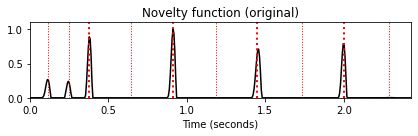

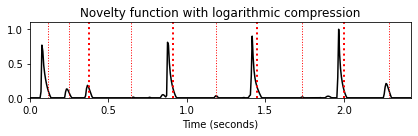

In [87]:
N = 2048
H = 128
nov_1, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=None)
nov_2, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=1000)

fig, ax, line = plot_signal(nov_1, Fs=Fs_nov, color='k', 
                    title='Novelty function (original)')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

fig, ax, line = plot_signal(nov_2, Fs=Fs_nov, color='k',
                    title='Novelty function with logarithmic compression')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

## 예시: 악기에 따라

- 온셋 감지의 또 다른 일반적인 문제는 비브라토 또는 트레몰로의 결과로 인한 비정상(nonsteady) 소리의 에너지 변동이다. 특히 순전히 에너지 기반의 절차의 경우 진폭 변조는 결과로 나타나는 노벨티 함수에서 가짜 피크로 이어지는 경우가 많다.
- 다른 악기로 연주되는 음 C4에 대한 에너지 기반 참신 기능을 보여주는 다음 예를 보자. 노벨티 기능은 피아노 소리의 경우 하나의 선명한 피크를 나타내지만 바이올린이나 플루트 소리의 경우 추가 피크가 많이 있다. 게다가, 바이올린 소리의 시작 부분에서 상대적으로 느린 에너지 증가는 얼룩지고 일시적으로 부정확한 온셋 피크로 이어진다.

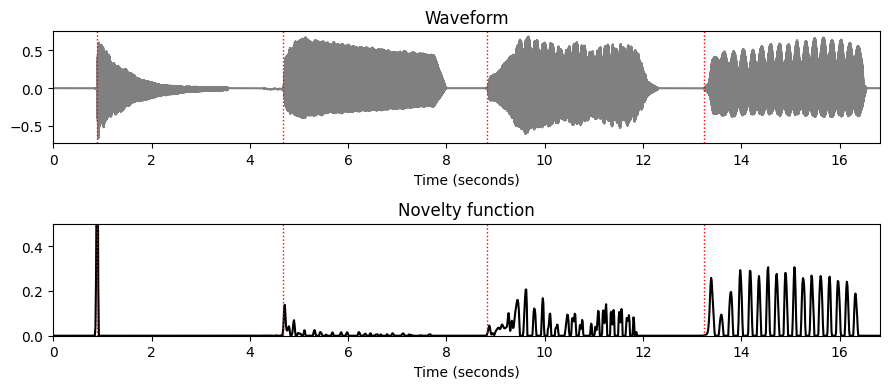

In [92]:
fn_ann = 'FMP_C6_F04_NoteC4_PTVF.csv'
ann, label_keys = read_annotation_pos(path_data+fn_ann, label='onset', header=0)

fn_wav = 'FMP_C6_F04_NoteC4_PTVF.wav'
x, Fs = librosa.load(path_data+fn_wav)
x_duration = len(x)/Fs
N = 2048
H = 256
nov, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=None)

plt.figure(figsize=(9,4))
ax = plt.subplot(2,1,1)
fig, ax, line = plot_signal(x, Fs, ax = ax, title='Waveform')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration)

ax = plt.subplot(2,1,2)
fig, ax, line = plot_signal(nov, Fs=Fs_nov, ax = ax, color='k', 
                     title='Novelty function')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                nontime_axis=True, time_min=0, time_max=x_duration)
plt.ylim([0, 0.5]);
plt.tight_layout()

ipd.display(Audio(data=x, rate=Fs))

# 스펙트럼 기반 노벨티 (Spectral-Based Novelty)

## Spectral-Based Novelty

- 동시에 발생하는 소리 이벤트가 있는 다성 음악의 경우 온셋 감지는 종종 어렵고 정의가 어려운 문제가 된다. 예를 들어, 낮은 강도의 음악 이벤트는 높은 강도의 이벤트에 의해 가려질 수 있다. 
- 그러나 잡음과 같은 광대역 과도 현상은 다성 혼합에서도 특정 주파수 대역에서 여전히 관찰될 수 있다.
- 이러한 관찰에 동기를 부여받은 **스펙트럼 기반 노벨티 탐지**의 아이디어는
     * 먼저 신호를 시간-주파수 표현으로 변환하고
     * 그런 다음 주파수 내용의 변경 사항을 캡처하는 것이다.
- 다음에서 $\mathcal{X}$를 샘플링 속도 $F_\mathrm{s}$, 윈도우 길이 $N$, 홉 사이즈 $H$ 을 사용한 DT-신호 $x$의 이산 STFT라고 하자.
- $\mathcal{X}(n,k)\in\mathbb{C}$는 주파수 인덱스 $k\in[0:K]$ 및 시간 프레임 $n\in\mathbb{Z}$에 대한 $k^\mathrm{th}$ 푸리에 계수를 나타낸다. 여기서 $K=N/2$는 Nyquist 주파수에 해당하는 주파수 인덱스이다.
- 신호의 스펙트럼 변화를 감지하기 위해 기본적으로 적절한 거리 측정을 사용하여 후속 스펙트럼 벡터 간의 차이를 계산한다.
- 그 결과 **스펙트럼 플럭스(spectral flux)** 라고도 하는 **스펙트럼 기반 노벨티 함수**가 생성된다.
- STFT와 거리 측정의 매개변수뿐만 아니라 종종 적용되는 전처리 및 후처리 단계에 따라 달라지는 노벨티 함수를 계산하는 방법에는 여러 가지가 있다.

## 로그 압축

- 먼저 약한 스펙트럼 성분을 강화하기 위해 **로그 압축**을 스펙트럼 계수에 적용한다. 이를 위해 크기 스펙트로그램 $|\mathcal{X}|$에 $\Gamma_\gamma$ 함수를 적용하면 다음을 얻는다.
    - $\mathcal{Y}:=\Gamma_\gamma(|\mathcal{X}|)=\log(1+ \gamma \cdot |\mathcal{X}|)$
    - 적절한 상수 $\gamma \geq 1$에 대해 

- \gamma=1$로 압축된 스펙트로그램을 사용하면 트랜지언트의 수직 구조가 더욱 두드러진다. 연속된 비트 사이의 하이햇의 약한 트랜지언트도 표시된다. $\gamma$를 높이면 특히 스펙트로그램의 고주파수 범위에서 낮은 강도 값이 더욱 향상된다. 
- 단점으로는 압축 계수 $\gamma$가 크면 관련 없는 노이즈와 같은 구성 요소가 증폭될 수도 있다.

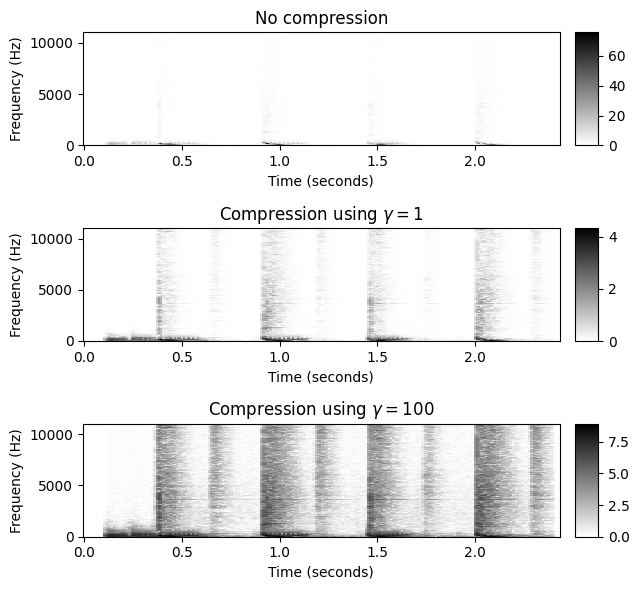

In [95]:
fn_ann = "FMP_C6_F01_Queen.csv"
ann, label_keys = read_annotation_pos(path_data+fn_ann)

fn_wav = 'FMP_C6_F01_Queen.wav'

x, Fs = librosa.load(path_data+fn_wav)
x_duration = len(x)/Fs
N, H = 1024, 256
X = librosa.stft(y=x, n_fft=N, hop_length=H, win_length=N, window='hann')

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 1, 1]}, figsize=(6.5, 6))        

Y = np.abs(X)
plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[0,0], ax[0,1]], title='No compression')

gamma = 1
Y = np.log(1 + gamma * np.abs(X))
plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[1,0], ax[1,1]], title='Compression using $\gamma=%0.0f$'%gamma)

gamma = 100
Y = np.log(1 + gamma * np.abs(X))
plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax[2,0], ax[2,1]], title='Compression using $\gamma=%0.0f$'%gamma)
plt.tight_layout()

## Discrete Derivative, Half-Wave Rectification, Accumulation

- 다음 단계에서는 압축된 스펙트럼 $\mathcal{Y}$의 이산 시간 도함수를 계산한다. 에너지 기반 노벨티 함수와 유사하게 **half-wave rectification**를 적용하여 양의 차이(강도 증가)만 고려하고 음의 차이는 버린다. 마지막으로 주파수 축(**누적** 단계)에서 양의 차이를 합산하여 **스펙트럼 기반 노벨티 함수** $\Delta_\mathrm{Spectral}:\mathbb{Z}\to \mathbb{R}$를 얻는다.:
    - $\Delta_\mathrm{Spectral}(n):= \sum_{k=0}^K  \big|\mathcal{Y}(n+1,k)-\mathcal{Y}(n,k)\big|_{\geq 0}$
    - for $n\in\mathbb{Z}$. 
- Queen 예에서, 결과의 노벨티 곡선은 사이사이의 낮은 에너지 하이햇 스트로크뿐만 아니라 높은 에너지를 가진 타악기 비트를 잘 나타낸다.

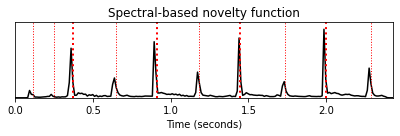

In [97]:
Y = np.log(1 + 100 * np.abs(X))
Y_diff = np.diff(Y, n=1)
Y_diff[Y_diff < 0] = 0
nov = np.sum(Y_diff, axis=0)
nov = np.concatenate((nov, np.array([0])))
Fs_nov = Fs/H

fig, ax, line = plot_signal(nov, Fs_nov, color='k', title='Spectral-based novelty function')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,  time_min=0, time_max=x_duration);

## Subtracting Local Average 

- 적절한 후처리 단계를 적용하여 노벨티 함수의 속성을 더욱 향상시킬 수 있다.
- 예를 들어, 연속의 피크 선택 단계의 관점에서 한가지 목적은 작은 변동을 억제하면서 노벨티 함수의 피크 구조를 향상시키는 것일 수 있다.
- 이를 위해 로컬 평균 함수 $\mu:\mathbb{Z}\to\mathbb{R}$를 다음과 같이 설정한다.
    - $\mu(n):= \frac{1}{2M+1}\sum_{m=-M}^M \Delta_\mathrm{Spectral}(n+m),$
    - $n\in\mathbb{Z}$, 여기서 $M\in\mathbb{N}$ 매개변수는 평균 창의 크기를 결정

- 향상된 노벨티 함수 $\bar{\Delta}_\mathrm{Spectral}$은 $\Delta_\mathrm{Spectral}$에서 로컬 평균을 빼고 양수 부분만 유지하여 얻는다(half-wave rectification).
    - $\bar{\Delta}_\mathrm{Spectral}(n):= \big|\Delta_\mathrm{Spectral}(n)-\mu(n)\big|_{\geq 0}$
    - for $n\in\mathbb{Z}$. 

- 다음 구현에서는 평균 창의 길이를 초 단위로 지정한다. 또한 결과 노벨티 함수를 최대값으로 나누어 정규화한다.

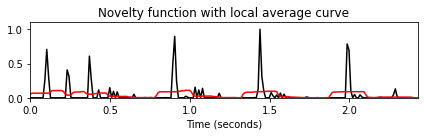

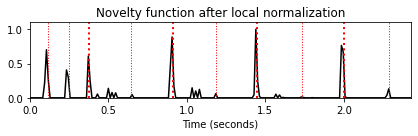

In [101]:
M_sec = 0.1
M = int(np.ceil(M_sec * Fs_nov))

local_average = compute_local_average(nov, M)
nov_norm =  nov - local_average
nov_norm[nov_norm<0]=0
nov_norm = nov_norm / max(nov_norm)

plot_signal(nov, Fs_nov, color='k', 
    title='Novelty function with local average curve');

t_novelty = np.arange(nov.shape[0]) / Fs_nov
plt.plot(t_novelty, local_average, 'r')
plt.tight_layout()

fig, ax, line = plot_signal(nov_norm, Fs_nov, color='k', 
                    title='Novelty function after local normalization')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

- 전체 절차를 `compute_novelty_spectrum` 함수로 보자.
- 스펙트럼 기반과 에너지 기반 노벨티 곡선을 비교해보자.

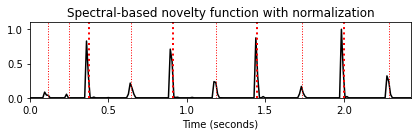

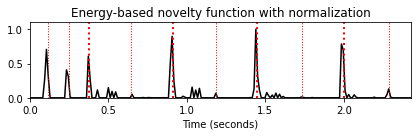

In [102]:
nov, Fs_nov = compute_novelty_spectrum(x, Fs=Fs, N=1024, H=256, gamma=10, M=10, norm=True)
fig, ax, line = plot_signal(nov, Fs_nov, color='k', 
                    title='Spectral-based novelty function with normalization')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

nov, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=1024, H=256, gamma=10)
fig, ax, line = plot_signal(nov, Fs_nov, color='k',
                    title='Energy-based novelty function with normalization')
plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    nontime_axis=True, time_min=0, time_max=x_duration);

# Phase-Based Novelty